# Notes

for the leoc96, I have to provide the left most values as the lon cordinates, instead of the center point, because if not it causes a crash 
for the gfdl (2pm) data we have to check this

Do I have to do this for all model data? 
If so, I might have to hard fix the crash that occurs when plotting using basemap. 

In [4]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy
import os
import pandas as pd
import cftime
import datetime as dt
import tqdm
import netCDF4 as nc

import os 
import glob
import subprocess

In [18]:
# reading in LEOC96 data
in_folder = '/mnt/drive3/gfdl/6HRLY/SURF/'

var = 'tp'
var_map = {'slp': 'slp', 'tp': 'pr', 'prw': 'PRW', 'clt': 'clt'}
var_units = {'slp': 'mb', 'tp': 'mm/hr', 'prw': 'mm/hr', 'clt': "{}".format('%')}
var_scale = {'tp': 3600., 'prw': 1., 'slp': 1., 'clt': 1.} 


out_var_map = {'slp': 'psl', 
               'tp': 'pr', 
               'prw': 'prw', 
               'clt': 'clt'}
out_var_units = {'slp': 'Pa', 
                 'prw': 'kg m-2', 
                 'tp': 'kg m-2 s-1', 
                 'clt': '1'}
out_var_scale = {'tp': 1., 
                 'prw': 1., 
                 'slp': 100., 
                 'clt': 1/100.} 
out_var_ln = {'slp': 'Sea Level Pressure', 
              'tp': 'Total Precipiation Flux', 
              'prw': 'Total Precipitable Water Vapor', 
              'clt': 'Total Cloud Fraction'}
out_var_sn = {'slp': 'air_pressure_at_mean_sea_level', 
              'prw': 'atmosphere_mass_content_of_water_vapor', 
              'tp': 'precipitation_flux', 
              'clt': 'cloud_area_fraction'}

in_file = f'/mnt/drive3/gfdl/6HRLY/SURF/atmos.2008010100-2012123123.{var_map[var]}.nc'

print(in_file)
print(os.path.exists(in_file))

/mnt/drive3/gfdl/6HRLY/SURF/atmos.2008010100-2012123123.pr.nc
True


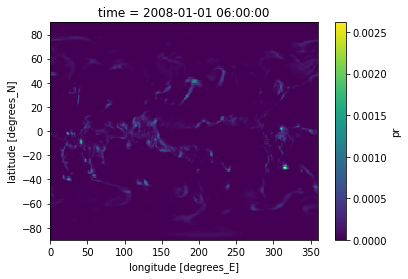

In [19]:
# print(subprocess.check_output(['ncdump', '-h', in_file]).decode('ascii'))
ds = xr.open_dataset(in_file)
# val = ds.pr.isel(time=0)
val = ds[var_map[var]].isel(time=0)
val = val*out_var_scale[var]
val.plot()

In [20]:
print(ds.variables[var_map[var]])

<xarray.Variable (time: 7308, lat: 180, lon: 288)>
[378846720 values with dtype=float32]
Attributes:
    long_name:      Total precipitation rate
    units:          kg/m2/s
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1


In [21]:
in_lat = ds.variables['lat'].values
in_lon = ds.variables['lon'].values
in_var = ds.variables[var_map[var]]

In [22]:
year_range = [2008, 2012]

time_start_year = 1975

# must include the end year, so have to add one 
num_years = year_range[1] - year_range[0] + 1

# creating the output arrays
out_time_bnds = np.zeros((1460*num_years, 2))

# time variable for all the years
in_time = np.arange(0, num_years*365, .25) + (year_range[0] - time_start_year)*365 
print(len(in_time))

7300


In [23]:
print(in_time[0])

12045.0


In [24]:
# selecting only the first 1460 to match the model output which is of a 365 year calendar
in_var = in_var.isel(time=range(len(in_time))).values * out_var_scale[var]

In [25]:
out_var = in_var 
out_time = in_time

In [26]:
lon = np.copy(in_lon)
dlon = lon[1] - lon[0]
out_lon = np.round(lon - dlon/2., decimals=2)

lat = np.copy(in_lat)
dlat = lat[1] - lat[0]
out_lat = np.round(lat - dlat/2., decimals=2)

# getting the output time bounds
out_time_bnds[:, 1] = out_time
out_time_bnds[0, 0] = out_time[0]
out_time_bnds[1:, 0] = out_time[:-1]

print(out_time_bnds.shape, out_lat.shape, out_lon.shape, out_var.shape)

(7300, 2) (180,) (288,) (7300, 180, 288)


## Creating the date variable provided in model data

In [27]:
# time_arr = [cftime.DatetimeNoLeap(time_start_year, 1, 1) + dt.timedelta(days=i) for i in tqdm.notebook.tqdm(out_time, total=len(out_time))]
out_date = np.empty(out_time.shape, dtype=int)
for i, i_time in tqdm.tqdm_notebook(enumerate(out_time), total=len(out_time)): 
    tmp = cftime.DatetimeNoLeap(time_start_year, 1, 1) + dt.timedelta(days=i_time)
    out_date[i] = int('%04d%02d%02d'%(tmp.year, tmp.month, tmp.day))

/home/jj/anaconda3/envs/mcms/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
print(out_date)

[20080101 20080101 20080101 ... 20121231 20121231 20121231]


# Creating the model sample data for the SLP values

In [29]:
# write the output as netcdf file 

# out_file = '/localdrive/drive10/jj/mdtf/inputdata/model/QBOi.EXP1.AMIP.001/6hr/QBOi.EXP1.AMIP.001.SLP.6hr.nc'
# out_file = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.SLP.6hr.nc'

# out_file = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.SLP.6hr.nc'
out_file = f'/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.{out_var_map[var]}.6hr.nc'
print(out_file)

# # Format of the PRECT variable for 3hr is as follows: 
# 1. time - noleap, days since 1975-01-01 00:00:00
# 2. date - current date
# 3. lat - latitude
# 4. lon - longitude
# 5. time_bnds - time interval endpoints
# 6. SLP - mba, long_name, cell_methods: "time:mean"

out_ds = xr.Dataset({
        'time_bnds': (('time', 'nbnd'), out_time_bnds), 
        'date': (('time'), out_date),
        out_var_map[var]: (('time', 'lat', 'lon'), out_var), 
    }, 
    coords={
        'time': out_time, 
        'lat': out_lat, 
        'lon': out_lon,
        'nbnd': [1, 2]
    },
    )

# lon attribs
out_ds.lon.attrs['standard_name'] = 'longitude'
out_ds.lon.attrs['long_name'] = 'longitude'
out_ds.lon.attrs['units'] = 'degrees_east'

# lat attribs
out_ds.lat.attrs['standard_name'] = 'latitude'
out_ds.lat.attrs['long_name'] = 'latitude'
out_ds.lat.attrs['units'] = 'degrees_north'

# time attribs
out_ds.time.attrs['standard_name'] = 'time'
out_ds.time.attrs['long_name'] = 'time'
out_ds.time.attrs['units'] = 'days since 1975-01-01 00:00:00'
out_ds.time.attrs['calendar'] = 'noleap'
out_ds.time.attrs['bounds'] = 'time_bnds'

# time_bnds attribs
out_ds.time_bnds.attrs['long_name'] = 'time interval endpoints'

# date attribs
out_ds.date.attrs['long_name'] = 'current date (YYYYMMDD)'

# slp attribs
out_ds[out_var_map[var]].attrs['long_name'] = out_var_ln[var]
out_ds[out_var_map[var]].attrs['standard_name'] = out_var_sn[var]
out_ds[out_var_map[var]].attrs['units'] = out_var_units[var]

print(out_file)

/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.pr.6hr.nc
/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.pr.6hr.nc


In [30]:
# actually writing the output file
out_ds.to_netcdf(out_file)

In [ ]:
file = '/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.TP.DEG10.001/6hr/ERA5.TP.DEG10.001.PRECT.6hr.nc'
file = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.PRECT.6hr.nc'
file = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.PRECT.6hr.nc'
ds = xr.open_dataset(file)
ds.close()
ds.PRECT.isel(time=10).plot()